In [42]:
!pip3 install langdetect
from langdetect import DetectorFactory, detect
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram
from matplotlib import pyplot as plt
import json
import re 
import numpy as np
import pandas as pd

In [43]:
with open("artist_lyrics_kaggle.json", "r", encoding='utf-8') as json_file:
  artist_lyrics = json.load(json_file)

with open("artist_genre_kaggle.json", "r", encoding='utf-8') as json_file:
  artist_genre = json.load(json_file)

In [44]:
def extract_artists_lyrics_of_file (json_file):
  json_file_content = {}
  for k,v in json_file.items(): 
    json_file_content[k] = ' '.join(re.findall('[A-Za-z]+', v))
  return json_file_content

def extract_genre_by_artist (json_file, artist):
  return json_file[artist]

def load_stopwords_file(txt_file):
  stopwords_file = open(txt_file)
  stopwords_file_content = stopwords_file.read()
  return stopwords_file_content.splitlines()

def detect_language (content):
  # check lg iso-codes here: https://en.wikipedia.org/wiki/List_of_ISO_639-1_codes
  return detect(content)

def evaluate_tfidf_matrix (stop_words, max_features, lyrics):
  vectorizer = TfidfVectorizer(stop_words=stop_words, max_features=max_features)
  lyrics_tfidf_matrix = vectorizer.fit_transform(lyrics)
  feature_names = vectorizer.get_feature_names()
  return lyrics_tfidf_matrix, feature_names

def extract_features_by_artist (json_content_artist_lyrics,stop_words,max_features):
  artists, lyrics = zip(*extract_artists_lyrics_of_file(json_content_artist_lyrics).items())
  lyrics_tfidf_matrix, feature_names = evaluate_tfidf_matrix(stop_words,max_features,lyrics)                             
  return zip(artists,lyrics_tfidf_matrix.toarray())

def extract_features_by_genre (json_content_artist_lyrics,json_content_artist_genre,stop_words,max_features):
  words_per_genre = {}
  for artist,lyrics in extract_artists_lyrics_of_file(json_content_artist_lyrics).items(): 
    genre = extract_genre_by_artist(json_content_artist_genre, artist)
    words_per_genre[genre] = lyrics if not genre in words_per_genre else words_per_genre[genre]+" "+lyrics
  genres, lyrics = zip(*words_per_genre.items())
  lyrics_tfidf_matrix, feature_names = evaluate_tfidf_matrix(stop_words,max_features,lyrics)        
  return zip(genres,lyrics_tfidf_matrix.toarray())

def apply_kmeans (json_content_artist_lyrics,stop_words,max_features):
  artists, lyrics = zip(*extract_artists_lyrics_of_file(json_content_artist_lyrics).items())
  lyrics_tfidf_matrix, feature_names = evaluate_tfidf_matrix(stop_words,max_features,lyrics)  
  kmeans = KMeans(n_clusters=10)
  kmeans.fit(lyrics_tfidf_matrix.toarray())
  y_kmeans = kmeans.predict(lyrics_tfidf_matrix.toarray()) 
  scatter_kmeans(kmeans,y_kmeans,lyrics_tfidf_matrix.toarray())                          

def scatter_kmeans(kmeans,y_kmeans,lyrics_tfidf_matrix):
  plt.scatter(lyrics_tfidf_matrix[:, 0], lyrics_tfidf_matrix[:, 1], c=y_kmeans, s=50, cmap='viridis')
  centers = kmeans.cluster_centers_
  plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

def apply_hierarchical_clustering (json_content_artist_lyrics,stop_words,max_features):
  artists, lyrics = zip(*extract_artists_lyrics_of_file(json_content_artist_lyrics).items())
  lyrics_tfidf_matrix, feature_names = evaluate_tfidf_matrix(stop_words,max_features,lyrics)                             
  clustered = linkage(lyrics_tfidf_matrix.toarray(), method='ward')
  plot_dendrogram(clustered, artists)

def plot_dendrogram(clustered, artists):
  plt.figure(figsize=(10, 25))
  plt.title('Hierarchical Clustering Dendrogram')
  plt.xlabel('Distance')  
  plt.ylabel('Artists')
  plt.tight_layout()
  dendrogram(clustered,leaf_font_size=8.,labels = artists,orientation = 'left')
  plt.show()
  
def apply_pca (json_content_artist_lyrics,stop_words,max_features):
  artists, lyrics = zip(*extract_artists_lyrics_of_file(json_content_artist_lyrics).items())
  genre_targets_df = pd.DataFrame ([extract_genre_by_artist(artist_genre,artist) for artist in artists],columns=['target'])
  lyrics_tfidf_matrix, feature_names = evaluate_tfidf_matrix(stop_words,max_features,lyrics)   
  pca = PCA(n_components=2)
  principal_components = pca.fit_transform(lyrics_tfidf_matrix.toarray())
  principal_components_df = pd.DataFrame(data = principal_components,columns = ['PC1', 'PC2'])
  principal_components_targets_df = pd.concat([principal_components_df, genre_targets_df], axis = 1)
  scatter_pca(principal_components_targets_df)
  
def scatter_pca(dataframe):
  fig = plt.figure(figsize = (8,8))
  ax = fig.add_subplot(1,1,1) 
  ax.set_xlabel('PC1', fontsize = 15)
  ax.set_ylabel('PC2', fontsize = 15)
  ax.set_title('Principle Component Analysis', fontsize = 20)
  targets = ['Metal','Hip-Hop','Electronic','R&B','Country','Folk','Pop','Indie','Rock','Jazz']
  colors = ["#c3618c","#b45ac2","#c8ac42","#7178ca","#cb7140","#4bafd0","#d0454e","#52a674","#877f3a","#5ac2bd"]
  for target, color in zip(targets,colors):
    indicesToKeep = dataframe['target'] == target
    ax.scatter(dataframe.loc[indicesToKeep, 'PC1']
                , dataframe.loc[indicesToKeep, 'PC2']
                , c = color
                , s = 50)
  ax.legend(targets)
  ax.grid()

In [45]:
artist_features_collection = extract_features_by_artist(artist_lyrics,load_stopwords_file("stopwords.txt"),20)
for artist_features in artist_features_collection: 
  print(artist_features)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'hadn', 'hasn', 'haven', 'isn', 'quelqu', 'shouldn', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


('annihilator', array([0.0273178 , 0.31716876, 0.17854181, 0.18718156, 0.0216386 ,
       0.19954673, 0.1697119 , 0.07279283, 0.37436313, 0.03119693,
       0.16989261, 0.24957542, 0.17854181, 0.        , 0.15598464,
       0.07984799, 0.61353957, 0.27037337, 0.00622117, 0.11370048]))
('busta-rhymes', array([0.14378449, 0.12256078, 0.0293295 , 0.04774456, 0.05044255,
       0.09668792, 0.03765435, 0.00984424, 0.03470094, 0.01747352,
       0.14718349, 0.19934585, 0.05045668, 0.70845626, 0.01353583,
       0.55221583, 0.07014021, 0.02928661, 0.17932904, 0.19320499]))
('crduan-xshadows', array([0.01813367, 0.40554446, 0.09585919, 0.19414362, 0.05835292,
       0.29193479, 0.        , 0.40985876, 0.37103004, 0.10354327,
       0.43572329, 0.17257211, 0.04357236, 0.        , 0.12942908,
       0.        , 0.29768689, 0.23728665, 0.00516204, 0.00943436]))
('fats-domino', array([0.53722901, 0.36924551, 0.11793196, 0.03471539, 0.11163924,
       0.07649641, 0.128763  , 0.1420175 , 0.03155945,

In [46]:
genre_features_collection = extract_features_by_genre(artist_lyrics,artist_genre,load_stopwords_file("stopwords.txt"),20)
for genre_features in genre_features_collection: 
  print(genre_features)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'hadn', 'hasn', 'haven', 'isn', 'quelqu', 'shouldn', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


('Metal', array([0.07090992, 0.2916229 , 0.19065845, 0.19065845, 0.04273379,
       0.13806302, 0.09485962, 0.15309028, 0.4696021 , 0.15402949,
       0.2009897 , 0.16436073, 0.36300242, 0.        , 0.2225914 ,
       0.06501061, 0.44847001, 0.26485558, 0.04789941, 0.11458291]))
('Hip-Hop', array([0.17999033, 0.23455642, 0.07350872, 0.08941204, 0.19260697,
       0.12570697, 0.0773962 , 0.04353978, 0.11849746, 0.0455542 ,
       0.23162314, 0.20960586, 0.17447718, 0.60462893, 0.0611748 ,
       0.4187969 , 0.17150856, 0.0651683 , 0.232542  , 0.24862203]))
('Electronic', array([0.15500641, 0.22797486, 0.1129568 , 0.26013045, 0.15583092,
       0.12449983, 0.11172005, 0.16654945, 0.20076629, 0.09646676,
       0.62579717, 0.25683244, 0.06967044, 0.00198639, 0.24652616,
       0.00760948, 0.26878772, 0.29269828, 0.04699663, 0.17479447]))
('R&B', array([0.46915234, 0.1442577 , 0.12508864, 0.13138504, 0.18259583,
       0.1123559 , 0.11067686, 0.15685052, 0.13054552, 0.08577107,
       0.64

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'hadn', 'hasn', 'haven', 'isn', 'quelqu', 'shouldn', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


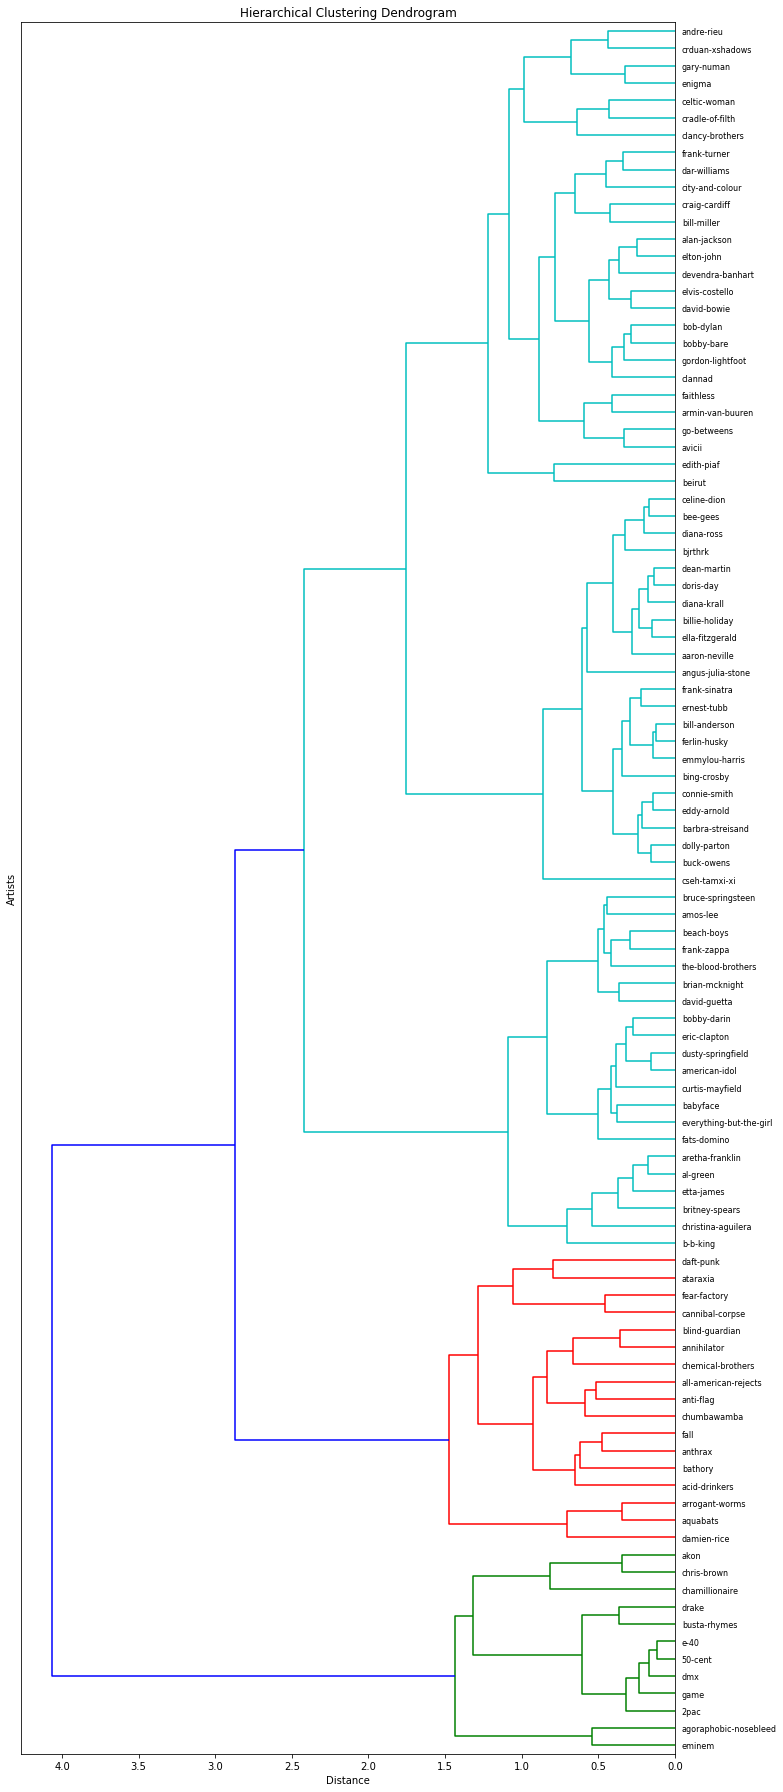

In [47]:
apply_hierarchical_clustering(artist_lyrics,load_stopwords_file("stopwords.txt"),20)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'hadn', 'hasn', 'haven', 'isn', 'quelqu', 'shouldn', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


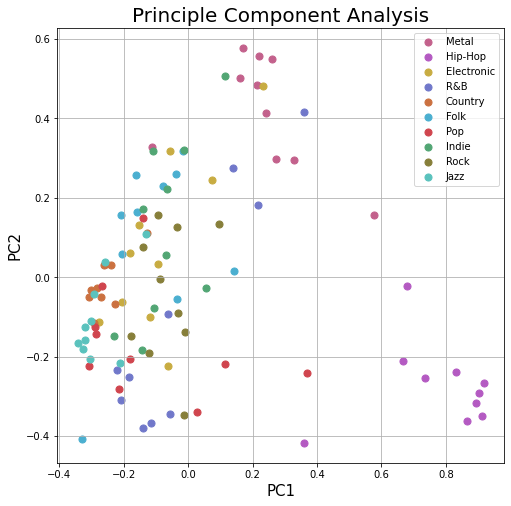

In [48]:
apply_pca(artist_lyrics,load_stopwords_file("stopwords.txt"),20)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'hadn', 'hasn', 'haven', 'isn', 'quelqu', 'shouldn', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


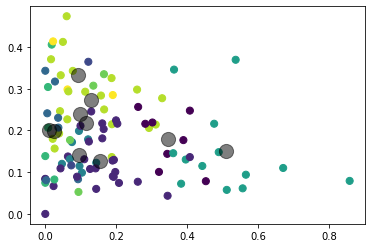

In [49]:
apply_kmeans(artist_lyrics,load_stopwords_file("stopwords.txt"),20)